# Plotting aggregate variables for multiple countries

In this notebook downloads time series of macroeconomic variables for multiple countries. It then plots selected ones in graphs. You will need to install the `eurostat' python package in order for the code to run.

In [1]:
import numpy as np
import eurostat
import matplotlib.pyplot as plt
import pandas as pd
import fredapi

To make the graphs more readable for color-blind people, use a color-blind friendly tableau

In [3]:
plt.style.use('tableau-colorblind10')
lines = ["-","--","-.",":","-","--","-.",":"]

## Downloading the relevant data series

In what follows, I download time series of the monthly unemployment rate directly from eurostat. 

In [12]:
unemp = eurostat.get_data_df('une_rt_m') #Monthly unemployment rate, percentage of labor force
unemp.head()

,freq,s_adj,age,unit,sex,geo\TIME_PERIOD,1983-01,1983-02,1983-03,1983-04,...,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06
0,M,NSA,TOTAL,PC_ACT,F,AT,NaN,NaN,NaN,NaN,...,4.9,4.6,4.5,5.2,4.6,4.5,5.0,4.5,4.3,4.8
1,M,NSA,TOTAL,PC_ACT,F,BE,NaN,NaN,NaN,NaN,...,5.3,5.3,5.2,5.2,5.1,4.9,4.8,4.8,4.9,4.9
2,M,NSA,TOTAL,PC_ACT,F,BG,NaN,NaN,NaN,NaN,...,3.7,4.0,4.2,4.4,4.9,5.0,5.0,5.0,4.7,4.5
3,M,NSA,TOTAL,PC_ACT,F,CH,NaN,NaN,NaN,NaN,...,4.7,4.2,4.1,4.2,4.4,4.4,4.4,NaN,NaN,NaN
4,M,NSA,TOTAL,PC_ACT,F,CY,NaN,NaN,NaN,NaN,...,4.3,4.4,6.3,6.6,6.7,6.3,5.3,4.2,3.8,5.0


This dataset contains much information we are not interested in, such as unemployment rates for men and women separately, for multiple age groups and so on. Hence, next, we restrict the dataframe to what we want: 
* Total unemployment rate
* Ages 25-75
* Seasonally adjusted
* Percent of total labor force

In [14]:
## Print the values which we can choose from, in the next step: choose. 
print(unemp.age.unique())
print(unemp.sex.unique())
print(unemp.s_adj.unique())
print(unemp.unit.unique())

['TOTAL' 'Y25-74' 'Y_LT25']
['F' 'M' 'T']
['NSA' 'SA' 'TC']
['PC_ACT' 'THS_PER']


In [15]:
unemp = unemp.loc[unemp['age'] == 'Y25-74'] #Unemployment rate for individuals aged 25-74
unemp = unemp.loc[unemp['sex'] == 'T'] #both sexes
unemp = unemp.loc[unemp['s_adj'] == 'SA'] #seasonally adjusted 
unemp = unemp.loc[unemp['unit'] == 'PC_ACT'] #as percentage of labor force

unemp = unemp.drop(['freq','s_adj','age','unit','sex'],axis=1)  #drop the columns that are no longer needed
unemp = pd.melt(unemp, id_vars=['geo\TIME_PERIOD'], var_name='time', value_name='value') #Reshape the data into long format
unemp = unemp.rename(columns={"geo\TIME_PERIOD": "country", "time": "month"})
unemp['mm'] = pd.to_datetime(unemp['month'])
print(unemp)



      country    month  value         mm
0          AT  1983-01    NaN 1983-01-01
1          BE  1983-01    NaN 1983-01-01
2          BG  1983-01    NaN 1983-01-01
3          CH  1983-01    NaN 1983-01-01
4          CY  1983-01    NaN 1983-01-01
...       ...      ...    ...        ...
17425      SI  2024-06    2.8 2024-06-01
17426      SK  2024-06    4.7 2024-06-01
17427      TR  2024-06    NaN 2024-06-01
17428      UK  2024-06    NaN 2024-06-01
17429      US  2024-06    3.3 2024-06-01

[17430 rows x 4 columns]


With the thus restricted dataframe in hand, we can now plot unemployment for the countries we are interested in. In our case, Germany, Denmark and Portugal. 

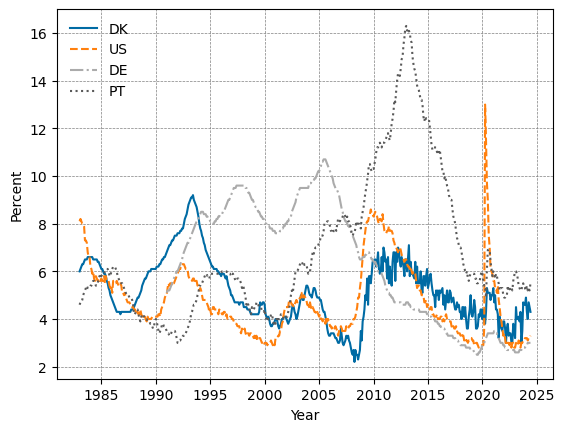

In [16]:
countrylist = ('DK','US', 'DE','PT') #List of countries to be plotted


ll=0
for country in countrylist:
    temp = unemp.loc[unemp['country'] == country] #Unemployment rate for individuals aged 25-74

    plt.plot(temp.mm,temp.value, label = country, linestyle = lines[ll])
    ll+=1
    
plt.legend(frameon=False,loc = 'upper left')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.ylabel('Percent')
plt.xlabel('Year')
plt.savefig('unemp_euro.pdf')
plt.show()

## GDP

The GDP values come from the OECD. The OECD has a lot of yearly economic aggregate time series for a long list of countries. Unfortunately, they recently changed their API, which means the code below is new and a work in progress. With the new API, downloading from the OECD has become a very messy affair. In the lecture, I'm using the old graphs. 

# Unemployment and GDP
In the next step, we plot unemployment and GDP together, in order to visualize the strong relationship between the two series. In this part, we focus on the US, as the National Bureau of Economic Research (NBER) has conveniently declared certain periods 'Recession'.

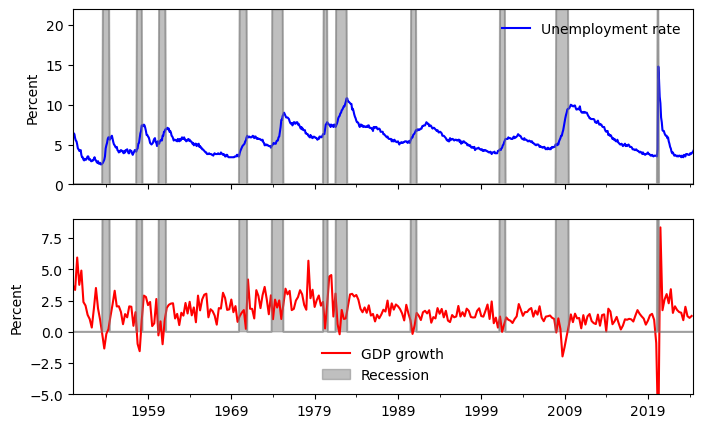

In [5]:
from fredapi import Fred #need to install this
fred = Fred(api_key='c0a963cd5bd17449f6d4b6a4e8d18f14')
mult = 22
us_gdp = fred.get_series('GDP') #gdp
us_unemp = fred.get_series('UNRATE') #unemployment
us_rec = fred.get_series('USREC')*mult #recession indicator
tmprec = us_rec*-1 #recession indicator

us_gdp_log  = np.log(us_gdp)
us_gdp_diff = us_gdp_log.diff()*100

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
us_unemp.plot.line(ax=ax1, figsize=(8, 5), x='DATE', color="blue", label = 'Unemployment rate')
us_rec.plot.area(ax=ax1, figsize=(8, 5), x='DATE', alpha=0.5, color="gray")
ax1.set_ylabel('Percent')
ax1.set_xlim("1950-01-01", "2024-06-01")
ax1.set_ylim(0,mult)
ax1.legend(frameon = False)

us_gdp_diff.plot.line(ax=ax2, figsize=(8, 5), x='DATE', color="red", label = 'GDP growth')
us_rec.plot.area(ax=ax2, figsize=(8, 5), x='DATE', alpha=0.5, color="gray", label = 'Recession')
ax2.set_xlim("1950-01-01", "2024-06-01")
ax2.set_ylim(-5,9)
ax2.set_ylabel('Percent')
ax2.legend(frameon = False)
plt.savefig('urate_gdp.pdf')

# Inflation and interest rates
Another very prominent and important relationship among macroeconomic variables is that of interest rates and inflation. 

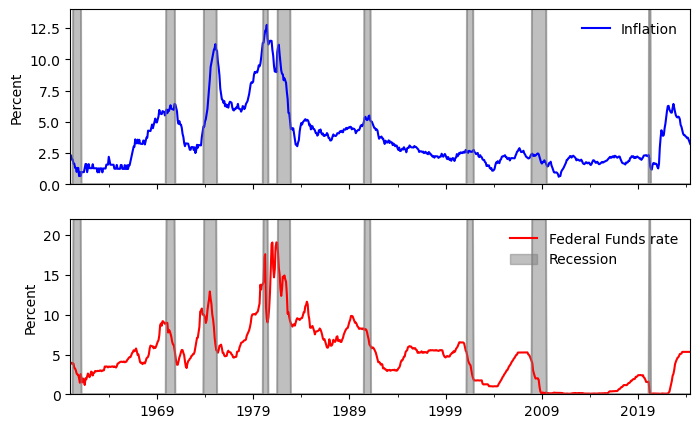

In [6]:
us_price_level = fred.get_series('CPILFESL') #Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average 
us_fed_i= fred.get_series('FEDFUNDS') #Fed funds rate

us_prices_log  = np.log(us_price_level)
us_infl = us_prices_log.diff(periods = 12)*100

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
us_infl.plot.line(ax=ax1, figsize=(8, 5), x='DATE', color="blue", label = 'Inflation')
us_rec.plot.area(ax=ax1, figsize=(8, 5), x='DATE', alpha=0.5, color="gray")
ax1.set_ylabel('Percent')
ax1.set_xlim("1959-01-01", "2024-06-01")
ax1.set_ylim(0,14)
ax1.legend(frameon = False)

us_fed_i.plot.line(ax=ax2, figsize=(8, 5), x='DATE', color="red", label = 'Federal Funds rate')
us_rec.plot.area(ax=ax2, figsize=(8, 5), x='DATE', alpha=0.5, color="gray", label = 'Recession')
ax2.set_xlim("1960-01-01", "2024-06-01")
ax2.set_ylim(0,22)
ax2.set_ylabel('Percent')
ax2.legend(frameon = False)
plt.savefig('inflation_fedfunds.pdf')

## Inflation and unemployment -- The Phillips Curve
Decades ago, there used to be a strong relationship between the rate of unemployment and the rate of wage growth. The relationship is also often expressed with inflation replacing wage growth.  

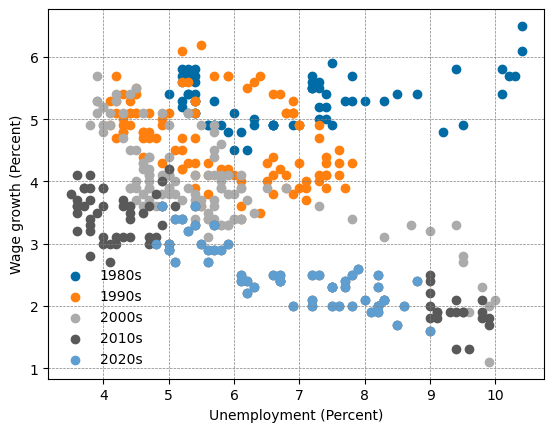

In [17]:
us_wage_growth = fred.get_series('FRBATLWGTUMHWG83O') #Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average 
us_unemp_cut = us_unemp[420:]

plt.scatter(us_unemp_cut[0:84],us_wage_growth[0:84],label= '1980s' )
plt.scatter(us_unemp_cut[84:203],us_wage_growth[84:203],label= '1990s' )
plt.scatter(us_unemp_cut[204:324],us_wage_growth[204:324],label= '2000s' )
plt.scatter(us_unemp_cut[324:444],us_wage_growth[324:444],label= '2010s' )
plt.scatter(us_unemp_cut[344:398],us_wage_growth[344:398],label= '2020s' )
plt.ylabel('Wage growth (Percent)')
plt.xlabel('Unemployment (Percent)')
plt.legend(frameon=False)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.savefig('philcurve.pdf')


## Government financing & central banking
One of the most impressive displays of the power of central bank credibility was on display when Mario Draghi, then head of the European Central Bank, announced that the institution would do "whatever it takes" to save the Euro. At the time, Greece's borrowing cost, as those of much of Southern Europe, had skyrocketed due to the European Sovereign Debt Crisis. The speech is considered a turning point

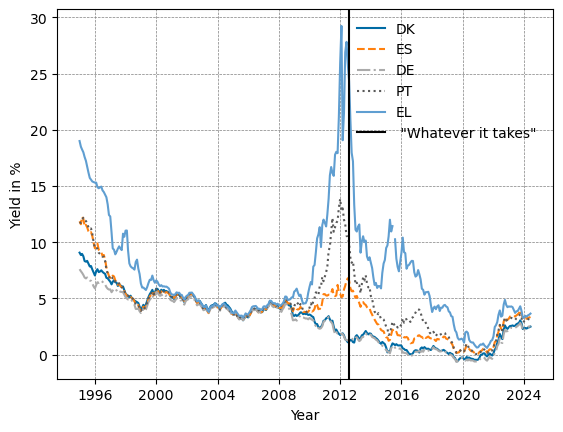

In [42]:
bonds = eurostat.get_data_df('irt_lt_mcby_m') #Monthly long term bond yields

bonds = bonds.drop(['freq','int_rt'],axis=1)  #drop the columns that are no longer needed
bonds = pd.melt(bonds, id_vars=['geo\TIME_PERIOD'], var_name='time', value_name='value') #Reshape the data into long format
bonds = bonds.rename(columns={"geo\TIME_PERIOD": "country", "time": "month"})
bonds['mm'] = pd.to_datetime(bonds['month'])

bonds.drop( bonds[ bonds['mm'] < pd.Timestamp(1995,1,1) ].index, inplace=True)

countrylist = ('DK','ES','DE', 'PT','EL') #List of countries to be plotted

ll=0
for country in countrylist:
    temp = bonds.loc[bonds['country'] == country]  #Unemployment rate for individuals aged 25-74
    
    plt.plot(temp.mm,temp.value, label = country, linestyle = lines[ll])
    ll+=1
plt.axvline(x = pd.Timestamp(2012,7,26) , color = 'black', label = ' "Whatever it takes" ')
plt.legend(frameon=False)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.xlabel('Year')
plt.ylabel('Yield in %')
plt.savefig('eurocrisis.pdf')